In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
import pandas as pd
from codex import io as codex_io
from codex import config as codex_config
from codex.function import data as function_data
from skimage import exposure
plt.gray()

<Figure size 432x288 with 0 Axes>

In [6]:
exp_name = '20180811-jurkat-labeled'
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'dna-stain', exp_name)
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'dna-stain', exp_name, 'output', 'v01')

#### Load Cytometry Data

In [7]:
config = codex_config.load(exp_conf_dir)

In [8]:
df = function_data.get_cytometry_data(exp_data_dir, config, mode='all')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5738 entries, 0 to 107
Data columns (total 31 columns):
region_index         5738 non-null int64
tile_index           5738 non-null int64
tile_x               5738 non-null int64
tile_y               5738 non-null int64
rid                  5738 non-null int64
rx                   5738 non-null float64
ry                   5738 non-null float64
id                   5738 non-null int64
x                    5738 non-null float64
y                    5738 non-null float64
z                    5738 non-null int64
cell_size            5738 non-null float64
cell_diameter        5738 non-null float64
cell_perimeter       5738 non-null float64
cell_solidity        5738 non-null float64
nucleus_size         5738 non-null float64
nucleus_diameter     5738 non-null float64
nucleus_perimeter    5738 non-null float64
nucleus_solidity     5738 non-null float64
ci:DAPI              5738 non-null float64
ci:GFP               5738 non-null float64
ci:PH

#### Load Image Tile

In [352]:
img_path = osp.join(exp_data_dir, codex_io.get_processor_img_path(0, 2, 2))
img_path

'/lab/data/dna-stain/20180811-jurkat-labeled/output/v01/processor/tile/R001_X003_Y003.tif'

In [353]:
tile = codex_io.read_tile(img_path)
tile.shape

(1, 28, 4, 1008, 1344)

In [354]:
img = tile[0, 14]
img = np.moveaxis(img, 0, -1)
img.shape

(1008, 1344, 4)

In [355]:
def plot_img(img, rng=[0, 50]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img[..., 0])
    ax[1].imshow(img[..., 1].clip(*rng))
    plt.gcf().set_size_inches(24,24)

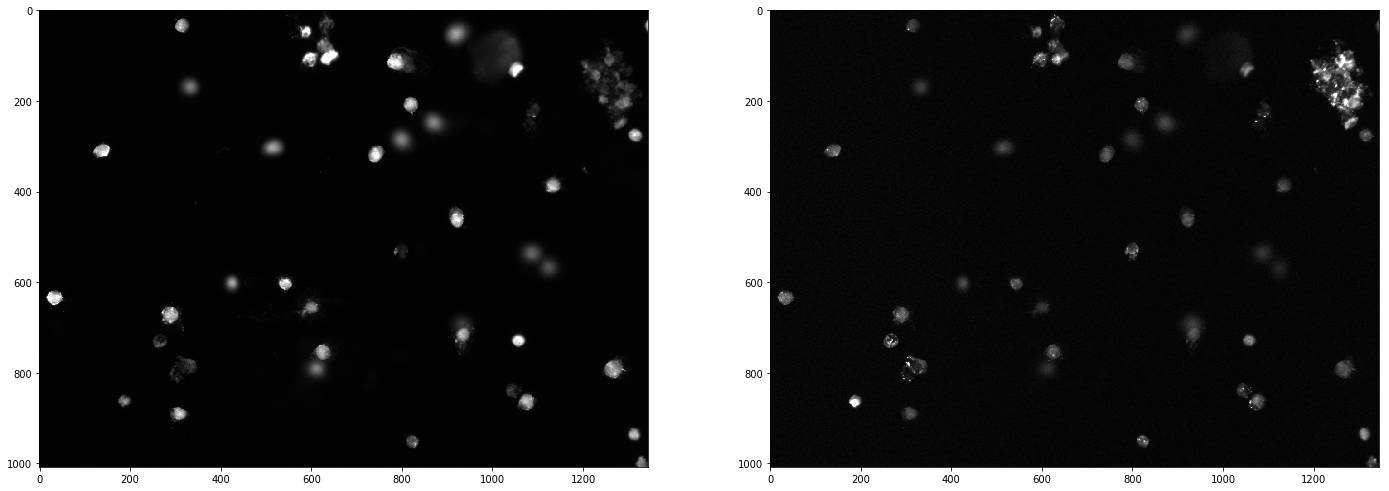

In [356]:
plot_img(img[..., 2:4])

#### Global Unmixing

In [331]:
df.filter(regex='^ci:').shape, df.filter(regex='^ci:').columns

((5738, 4),
 Index(['ci:DAPI', 'ci:GFP', 'ci:PHA', 'ci:Plasmid'], dtype='object'))

In [332]:
features = df.filter(regex='^ci:').columns.tolist()
#features = ['ci:PHA', 'ci:Plasmid']
features

['ci:DAPI', 'ci:GFP', 'ci:PHA', 'ci:Plasmid']

In [333]:
#df[features].plot(kind='scatter', x=features[0], y=features[1])

In [362]:
from sklearn.decomposition import NMF
#from sklearn.decomposition import FastICA

def get_decomposition(df):
    X = df[features].values
    #return NMF(max_iter=1000, init='nndsvda').fit(X)
    
    # See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3832632/
    W = np.random.rand(*X.shape)
    H = (np.eye(X.shape[1], dtype='float') + .25) * (4/5.)
    print(H)
    return NMF(max_iter=1000, init='custom').fit(X, W=W, H=H)
    
    #return FastICA(max_iter=1000).fit(X)

decomp = get_decomposition(df)

[[1.  0.2 0.2 0.2]
 [0.2 1.  0.2 0.2]
 [0.2 0.2 1.  0.2]
 [0.2 0.2 0.2 1. ]]


In [363]:
decomp.reconstruction_err_

5.282468119193084

In [364]:
decomp.n_iter_

378

In [366]:
decomp.components_

array([[0.9449295 , 0.00777211, 0.06448493, 0.00579429],
       [0.02395866, 1.14348834, 0.36373219, 0.03099717],
       [0.        , 0.        , 1.44971766, 0.07176121],
       [0.        , 0.        , 0.30068586, 3.74084757]])

In [372]:
pd.DataFrame(decomp.components_, columns=features, index=features)

,ci:DAPI,ci:GFP,ci:PHA,ci:Plasmid
ci:DAPI,0.944929,0.007772,0.064485,0.005794
ci:GFP,0.023959,1.143488,0.363732,0.030997
ci:PHA,0.000000,0.000000,1.449718,0.071761
ci:Plasmid,0.000000,0.000000,0.300686,3.740848


In [374]:
pd.DataFrame(decomp.components_, columns=features, index=features).stack().reset_index().iloc[0].to_dict()

{0: 0.9449294983444904, 'level_0': 'ci:DAPI', 'level_1': 'ci:DAPI'}

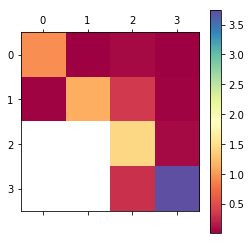

In [338]:
plt.matshow(np.where(decomp.components_ > 0, decomp.components_, np.nan), cmap='Spectral')
plt.colorbar()

In [357]:
def apply_decomposition(decomp, img):
    shape = img.shape
    X = img.reshape((-1, len(features)))
    Y = decomp.transform(X)
    return Y.reshape(shape)

In [359]:
#res = apply_decomposition(decomp, img[..., 2:4])
res = apply_decomposition(decomp, img)

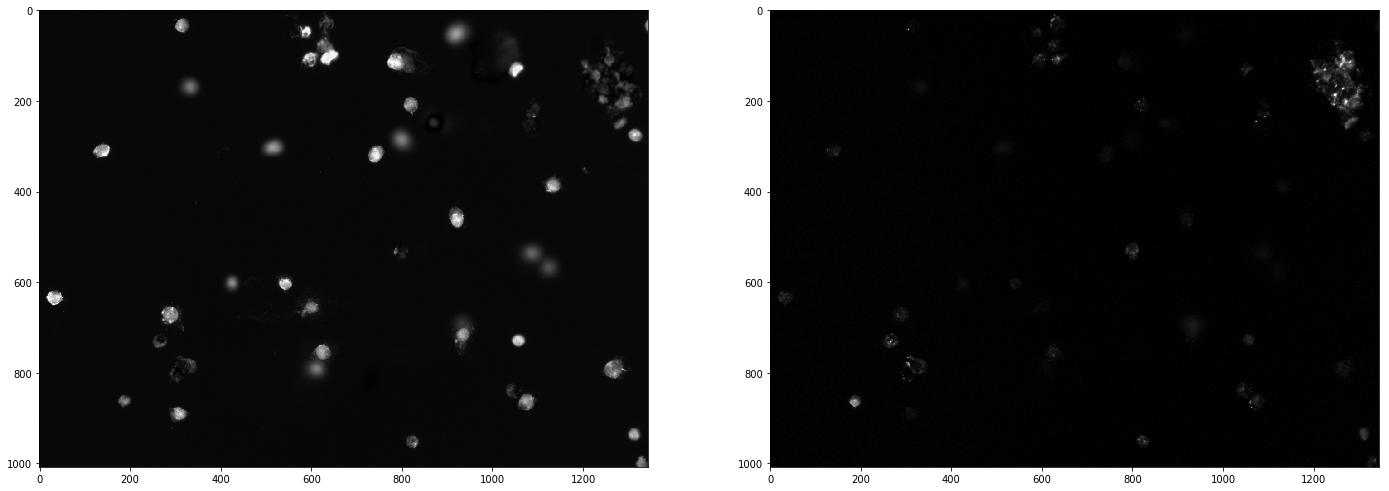

In [360]:
#plot_img(res[..., 2:4], rng=[0, 15])
plot_img(res[..., 2:4], rng=[0, 25])

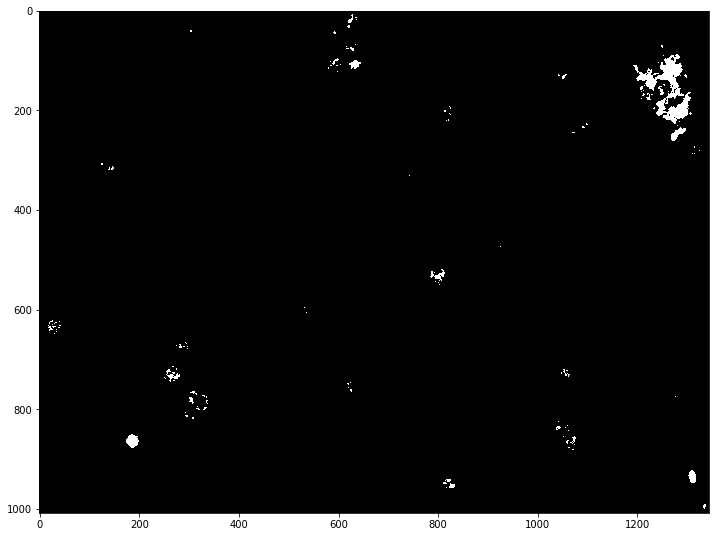

In [361]:
from skimage import filters
#plt.imshow(filters.threshold_otsu(res[..., 3]))
plt.imshow(res[..., 3] > filters.threshold_otsu(res[..., 3]))
plt.gcf().set_size_inches(12, 12)

#### Local Unmixing

In [ ]:
from sklearn.decomposition import NMF

def get_unmixed_image(img):
    shape = img.shape
    X = img.reshape((-1, 4))
    decomp = NMF(init='custom', max_iter=1000)
    W = np.random.rand(*X.shape)
    H = (np.eye(X.shape[1], dtype='float') + .25) * (4/5.)
    Y = decomp.fit_transform(X, W=W, H=H)
    return decomp, X.reshape(shape), Y.reshape(shape)

In [ ]:
decomp, X, Y = get_unmixed_image(img)

In [ ]:
decomp.components_

In [135]:
decomp.n_iter_

238

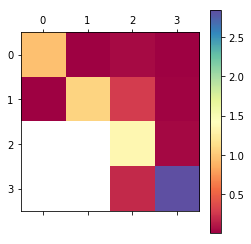

In [136]:
plt.matshow(np.where(decomp.components_ > 0, decomp.components_, np.nan), cmap='Spectral')
plt.colorbar()

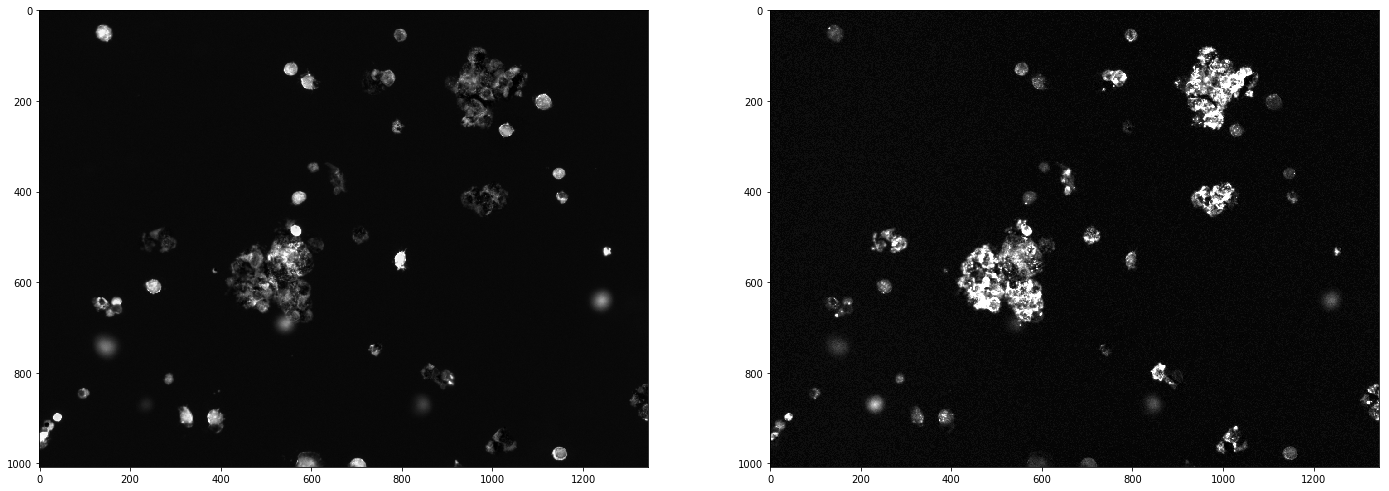

In [137]:
plot_img(Y, rng=[0, 10])